<a href="https://colab.research.google.com/github/micaelleos/ia-projects-notebooks/blob/main/Classification%20Pneumonia%20-%20Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 Image Classification

- Ingest data
- Preprocess data
- Process dataset
- Model creation
- Model Training
- Model evaluation

### Loading Liberys

In [2]:
import tensorflow as tf


## Dataset Ingestion

Dataset: https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets/code

Adicione o arquivo kaggle.json no diretório .kaggle, para que a API de ingestão tenha a chave da sua conta.

In [3]:
!pip install kaggle

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khoongweihao/covid19-xray-dataset-train-test-sets")

print("Path to dataset files:", path)

100%|██████████| 84.3M/84.3M [00:01<00:00, 53.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khoongweihao/covid19-xray-dataset-train-test-sets/versions/1


In [5]:
test_path = path + "/xray_dataset_covid19/test"
train_path = path + "/xray_dataset_covid19/train"

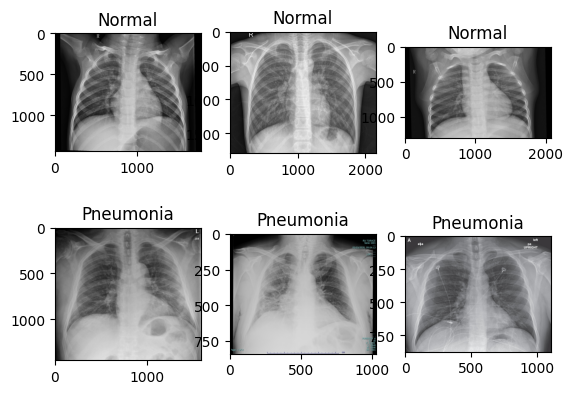

In [25]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

img_path_normal = os.listdir(train_path + "/NORMAL")
img_path_pneumonia = os.listdir(train_path + "/PNEUMONIA")

train_path_normal =[train_path + "/NORMAL/" + i for i in img_path_normal]
train_path_pneumonia =[train_path + "/PNEUMONIA/" + i for i in img_path_pneumonia]

img_normal =[np.array(Image.open(img)) for img in train_path_normal[:3]]
img_pneumonia =[np.array(Image.open(img)) for img in train_path_pneumonia[:3]]

for idx, img in enumerate(img_normal):
  plt.subplot(2, 3, idx+1)
  plt.title("Normal")
  plt.imshow(img, cmap='gray')
for idx, img in enumerate(img_pneumonia):
  plt.subplot(2, 3, idx+4)
  plt.title("Pneumonia")
  plt.imshow(img, cmap='gray')

plt.show()

In [7]:
# verificando dimensões das imagens
img_normal[0].shape

(1440, 1784)

In [75]:
# criando dataframe com as labels das imagens para análise posterior
import pandas as pd

img_path_n = os.listdir(test_path + "/NORMAL")
img_path_p = os.listdir(test_path + "/PNEUMONIA")

test_path_normal =[test_path + "/NORMAL/" + i for i in img_path_n]
test_path_pneumonia =[test_path + "/PNEUMONIA/" + i for i in img_path_p]

classes = ['Normal' for i in range(len(test_path_normal))] + ['Pneumonia' for i in range(len(test_path_pneumonia))]
img = test_path_normal + test_path_pneumonia
dados = {
    'img': img,
    'Classe': classes
}


In [77]:
df = pd.DataFrame(dados)
df.head(5)

,img,Classe
0,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal
1,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal
2,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal
3,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal
4,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal


In [78]:
df.shape

(40, 2)

- Criar um dataframe com o path do arquivo e clasificação real

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            labels='inferred',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            labels='inferred',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [10]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Criando o Modelo

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
    pooling="max",
    classifier_activation='softmax'
)
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
IMG_SHAPE

(160, 160, 3)

In [13]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the complete model
model = tf.keras.Model(inputs, outputs)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Treinamento do Modelo

In [14]:
# Define early stopping callback to stop training when validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

In [15]:
# Set the number of epochs for initial training
initial_epochs = 40

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4597 - loss: 66.0385 - val_accuracy: 0.5000 - val_loss: 29.9349
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4601 - loss: 39.6312 - val_accuracy: 0.6000 - val_loss: 9.3076
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5914 - loss: 32.7904 - val_accuracy: 0.7500 - val_loss: 5.3131
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5637 - loss: 30.4618 - val_accuracy: 0.6750 - val_loss: 10.2092
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6752 - loss: 18.1085 - val_accuracy: 0.8750 - val_loss: 1.8586
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6788 - loss: 22.6740 - val_accuracy: 0.8750 - val_loss: 1.7546
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6756 - loss: 21.9326 - val_accuracy: 0.8500 - val_loss: 3.7592
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6921 - loss: 22.7600 - val_accuracy: 0.9250 - val_loss: 0.791

### Fine-Tune do modelo

In [16]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 79, 79, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 79, 79, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 79, 79, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 77, 77, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 77, 77, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 77, 77, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 77, 77, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 77, 77, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 77, 77, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 38, 38, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 38, 38, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 38, 38, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 38, 38, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 36, 36, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 36, 36, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [17]:
# verificando modelo atual
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,933 (83.19 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 4,100 (16.02 KB)

In [18]:
# Desconogelando treinamento das camadas modelo inception
base_model.trainable = True
fine_tune_at = 249 # specific to this architecture

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,808,933 (83.19 MB)

 Trainable params: 11,116,929 (42.41 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

 Optimizer params: 4,100 (16.02 KB)

In [20]:
# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
# Set the number of epochs for fine-tuning
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs  # Total epochs

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
    validation_data=test_dataset,
    callbacks=[early_stopping]  # Use early stopping
)

Epoch 20/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5470 - loss: 2.4078 - val_accuracy: 0.6250 - val_loss: 2.9342
Epoch 21/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5713 - loss: 1.6645 - val_accuracy: 0.6000 - val_loss: 2.4299
Epoch 22/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6223 - loss: 0.9272 - val_accuracy: 0.5750 - val_loss: 2.0427
Epoch 23/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6758 - loss: 0.8849 - val_accuracy: 0.5750 - val_loss: 1.7409
Epoch 24/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8062 - loss: 0.4926 - val_accuracy: 0.6000 - val_loss: 1.5158
Epoch 25/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8878 - loss: 0.2504 - val_accuracy: 0.6250 - val_loss: 1.3198
Epoch 26/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9330 - loss: 0.1652 - val_accuracy: 0.6250 - val_loss: 1.1673
Epoch 27/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9210 - loss: 0.1904 - val_accuracy: 0.6250 - val_loss: 1.0571


In [23]:
# Salvar pesos em um arquivo H5
model.save_weights('meu_modelo_pesos.weights.h5')
# Salvar pesos no formato SavedModel
model.save('meu_modelo_pesos.h5')


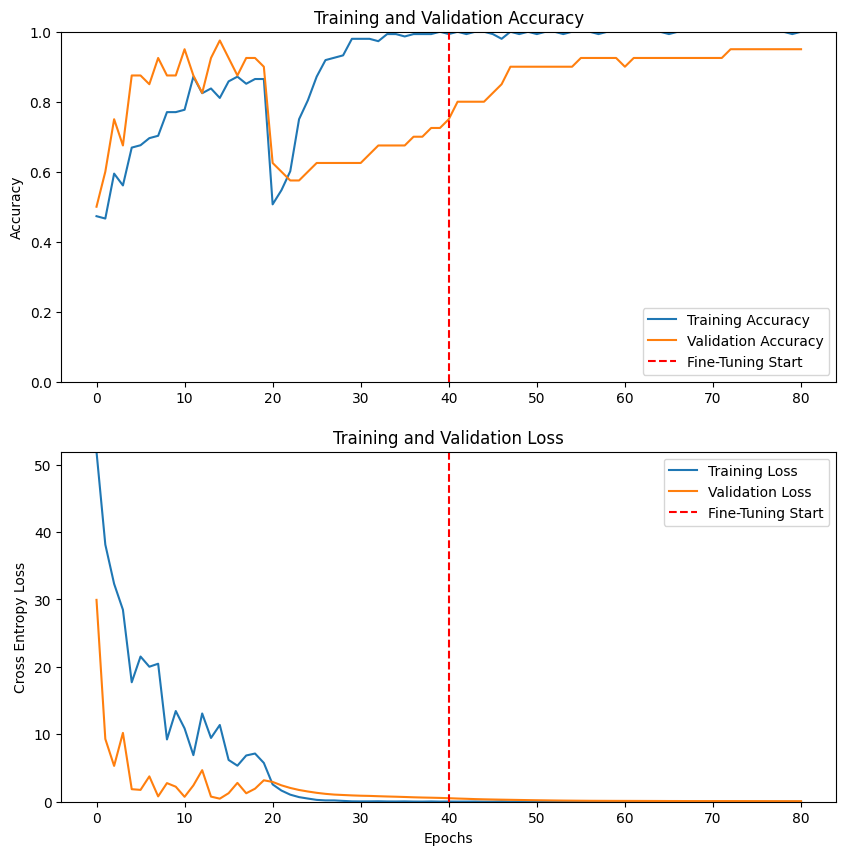

In [24]:
# Plot de métricas de treinamento
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Total epochs
total_epochs = len(acc)
fine_tune_start = initial_epochs  # Epoch where fine-tuning starts

plt.figure(figsize=(10, 10))

# plot de acurácia
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()


## Avaliação do Modelo

In [126]:
# Abrindo imagens do conjunto de dados de test
import cv2
import numpy as np

def predict_images(path_list):
  result = []
  for i in path_list:
    # Carregar a imagem em tons de cinza
    image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (160,160))
    # Converter para 3 canais
    imagem_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    img = np.array(imagem_rgb)
    img = np.expand_dims(img, axis=0)
    result.append(model.predict(img)[0][0])
  return result


In [127]:
# Predição das imagens de teste
result = predict_images(df["img"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/s

In [165]:
# Guardando informações no dataframe com os dados de teste
df['prob'] = result

### Avaliação do classificador para um limiar de 50%

In [ ]:
pred = []

for i in df['prob']:
  if i >= 0.5:
    pred.append("Pneumonia")
  else:
    pred.append("Normal")

df["pred"] = pred

In [166]:
df[:5]

,img,Classe,pred,prob
0,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal,Normal,0.413576
1,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal,Normal,0.001271
2,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal,Normal,0.071920
3,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal,Normal,0.009663
4,/root/.cache/kagglehub/datasets/khoongweihao/c...,Normal,Normal,0.001812


In [167]:
print("Precisão do :", sum(df["Classe"] == df["pred"])/len(df))

Precisão: 0.95


### Encontrando melhor limiar de classificação

In [157]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
labels = df["Classe"] == "Pneumonia"
y_pred_proba = df["prob"]
# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(labels, y_pred_proba)
roc_auc = auc(fpr, tpr)

In [158]:
thresholds

array([          inf, 1.0000000e+00, 9.9999988e-01, 7.7332091e-01,
       7.0252936e-05], dtype=float32)

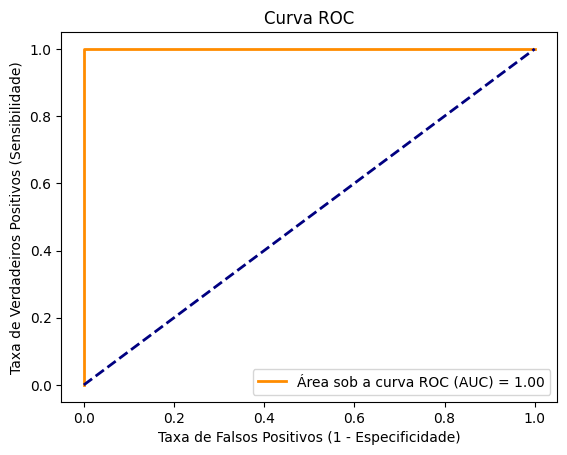

In [159]:
# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Área sob a curva ROC (AUC) = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

## Teste com imagem de outro Dataset

In [153]:
def predict_image(i):
  # Carregar a imagem em tons de cinza
  image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (160,160))
  # Converter para 3 canais
  imagem_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  img = np.array(imagem_rgb)
  img = np.expand_dims(img, axis=0)
  result = model.predict(img)[0][0]
  return result

Teste de exame de outro dataset com pneumonia.

In [154]:
resultado = predict_image("/content/25907157.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [156]:
if resultado > 0.5:
  print("Amostra com Pnemonia")

Amostra com Pnemonia
